In [1]:
#!/usr/bin/env python3
"""
Offset-free MPC (CT) migrated from `control/offset_free_CT.ipynb`.

- Loads A, B, C, trained Koopman-related modules, scalers, and sim setup
- Builds transformed representation with T_real
- Runs target estimation + MPC closed-loop simulation
- Saves plots under repository `figures/`
- Prints the objective line exactly as in the notebook:
  "Closed-loop objective function value: <value>"

Requires `src/helper` and `src/models` to be importable.
"""

from __future__ import annotations

import sys
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from tqdm import tqdm

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore
from neuromancer.loss import PenaltyLoss  # type: ignore

# Add Identification directory to path for baseline_inference import
identification_path = Path.cwd().resolve().parent / 'Identification'
if str(identification_path) not in sys.path:
    sys.path.append(str(identification_path))
import baseline_inference  # type: ignore




Helper imported succesfully


In [2]:
baseline_inference.init()

Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs


In [3]:
# --------------------------- Repository paths ---------------------------------

def get_repo_root() -> Path:
    # In a notebook, __file__ is not defined; use cwd as a fallback
    return Path.cwd().resolve().parent


def get_figures_dir(repo_root: Path) -> Path:
    figures = repo_root / "figures"
    figures.mkdir(parents=True, exist_ok=True)
    return figures


# # Ensure `src` is on PYTHONPATH
REPO_ROOT = get_repo_root()
SRC_PATH = REPO_ROOT / 'src'
if SRC_PATH.as_posix() not in sys.path:
    sys.path.append(SRC_PATH.as_posix())

import helper  # type: ignore
import models  # type: ignore


# # ------------------------------ IO utilities ----------------------------------






# def load_scalers(data_dir: Path):
#     scaler = joblib.load((data_dir / 'scaler.pkl').as_posix())
#     scalerU = joblib.load((data_dir / 'scalerU.pkl').as_posix())
#     return scaler, scaler



Models imported succesfully


In [4]:
data_dir = REPO_ROOT / '../data'
figures_dir = get_figures_dir(REPO_ROOT)

# Load matrices for matrix_C=False as in notebook
matrix_C = True
A = np.load(f"../data/A_parsimK.npy")
B = np.load(f"../data/B_parsimK.npy")
C = np.load(f"../data/C_parsimK.npy")

# # Resample A and B from Ts=1 to Ts=10 seconds
# Ts_old = 1.0    # original timestep in seconds
# Ts_new = 10.0   # desired timestep in seconds

# # import scipy.linalg as la

# # # Convert to continuous through matrix log
# # Ac = la.logm(A) / Ts_old
# # Bc = np.linalg.solve(Ac, (A - np.eye(A.shape[0]))) @ B

# # # Re-discretize at Ts_new
# # A = A_10 = la.expm(Ac * Ts_new)
# # B = B_10 = np.linalg.solve(Ac, (A_10 - np.eye(A.shape[0]))) @ Bc

# # A = np.real(A)  # or use np.real(A_10) if you're sure
# # B = np.real(B)

# # np.save(f"../data/A_parsimK_Ts.npy", A)
# # np.save(f"../data/B_parsimK_Ts.npy", B)

# A_10 = np.linalg.matrix_power(A, int(Ts_new / Ts_old))

# sum_term = np.zeros_like(B)
# A_power = np.eye(A.shape[0])
# for i in range(int(Ts_new / Ts_old)):
#     sum_term += A_power @ B
#     A_power = A @ A_power
# B_10 = sum_term

# A = A_10
# B = B_10


nz, nu = B.shape
ny = C.shape[0]

# Disturbance model dimension
F = np.eye(ny)
nd = F.shape[1]

# Block diagonalization
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print("Backtransformation equals original A?", np.allclose(A, A_backtransformed, atol=1e-6))
# T_real = np.eye(nz)  # Use identity for now, as A is already block diagonal



Close to block diagonal? True
Backtransformation equals original A? True


In [5]:
B.shape

(3, 3)

In [6]:
# Apply transformation as in notebook (Cell 6)
A = inv(T_real) @ A @ T_real
B = inv(T_real) @ B
C = C @ T_real

# Load scalers
scaler, scalerU = baseline_inference.scaler, baseline_inference.scalerU
# Sim setup
loaded_setup = joblib.load("sim_setup.pkl")


In [7]:

y_start = loaded_setup['y_start']
y_start_ns = loaded_setup.get('y_start_ns')
reference_ns = loaded_setup.get('reference_ns')
y_setpoint = loaded_setup['reference'][:, 0]
u_sp = loaded_setup['reference_u']
u_previous = loaded_setup['u_previous']
u_previous_ns = loaded_setup.get('u_previous_ns')

# Initial state estimate includes disturbance
z_est_ = np.hstack(((np.linalg.pinv(C) @ y_start.T).T, np.zeros((1, nd))))
P0 = np.eye(nz + nd)*loaded_setup['P0']
Q = np.block([
        [np.eye(nz) * 0.1,  np.zeros((nz, nd))],   # Trust state model
        [np.zeros((nd, nz)), np.eye(nd) * 1]      # Disturbance adapts fast
    ]) 
R = np.eye(ny)*0.01
Cd = np.eye(ny)
Bd = np.zeros((nz, nd))
# Cd = np.zeros((ny,nd))
# Bd = B

A_ = np.block([
    [A, Bd],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])

C_ = np.hstack([
    C, Cd,
])

KF = helper.KF(A_, B_, C_, z_est_, P0, Q, R)



In [8]:
P0.shape

(6, 6)

In [9]:
nd

3

In [10]:
z_est_[:, :]

array([[0.25027559, 0.32927225, 0.09131633, 0.        , 0.        ,
        0.        ]])

In [11]:
# Target calc
target_estimation = helper.TargetEstimation(A, B, C, loaded_setup['Qy_te'], loaded_setup['Qu_te'], Bd, Cd)
z_s, y_s, u_s = target_estimation.get_target(z_est_[:, nz:], y_setpoint, u_sp)
target_energy_estimation = helper.TargetEnergyEstimation(A, B, C, loaded_setup['Qe_te'], Bd, Cd)
z_s_energy, y_s_energy, u_s_energy = target_energy_estimation.get_target(z_est_[:, nz:], y_s, u_s)
z_ref = z_s_energy


Set parameter Username
Set parameter LicenseID to value 2631450
Academic license - for non-commercial use only - expires 2026-03-05


In [12]:
z_s

array([0.02430355, 0.09932668, 0.08679059])

In [13]:
y_s - y_setpoint

array([ 4.38456382e-10, -7.90806419e-01, -1.80251952e-01])

In [14]:
# Before calling build_problem, check Qu as well
print("Qu is PSD?", np.all(np.linalg.eigvalsh(loaded_setup['Qu']) >= -1e-10))

Qu is PSD? True


In [15]:
Qx = C.T@loaded_setup['Qy']@C + 2e-8 * np.eye(A.shape[0])



# Check if Qx is positive semi-definite
eigvals = np.linalg.eigvals(Qx)
# min_eigval = np.min(eigvals)
# if min_eigval < 0:
#     # Add enough regularization to make it PSD
#     Qx = Qx + (abs(min_eigval) + 1e-6) * np.eye(A.shape[0])

is_psd = np.all(eigvals >= 1e-8)
is_psd


np.True_

In [16]:
A


array([[ 9.76944402e-01,  4.25337316e-16, -3.06533989e-16],
       [-1.43539334e-15,  9.69721362e-01, -2.73626877e-16],
       [ 8.00442967e-17, -2.35613462e-17,  8.85478994e-01]])

In [17]:
B

array([[-0.01212693, -0.00219027,  0.04100532],
       [-0.01610509, -0.00045546,  0.03906379],
       [-0.01178802,  0.02359101, -0.01520195]])

In [18]:
C

array([[-0.1472301 ,  1.32230463,  3.04085738],
       [ 2.73722413, -1.97147131, -1.07130226],
       [-0.38614972,  1.55335381,  2.79650526]])

In [19]:
# import numpy as np
# import numpy.linalg as la

# # ----- your model (discrete, Ts = 10 s, D = 0) -----
# Ts = 10.0


# # Optional labels (edit to your meaning/order)
# state_names = ["T_boiler (x1)", "T_HX_out (x2)", "T_hold_end (x3)"]
# input_names = ["feed pump (u1)", "heat pump (u2)", "boiler power (u3)"]
# output_names = ["y1", "y2", "y3"]  # replace if y = temperatures or some linear combos


# # ----- computations -----
# def dc_gain_discrete(A, B, C):
#     """G0 = C (I - A)^(-1) B   (D assumed zero)"""
#     n = A.shape[0]
#     return C @ la.solve(np.eye(n) - A, B)

# def markov_params(A, B, C, N=80):
#     """
#     Impulse response Markov parameters:
#       G[k] = C A^(k-1) B, k>=1.  (D assumed zero)
#     """
#     p, m = C.shape[0], B.shape[1]
#     G = np.zeros((N + 1, p, m))
#     Ak = np.eye(A.shape[0])  # A^(k-1) at k=1
#     for k in range(1, N + 1):
#         G[k] = C @ Ak @ B
#         Ak = Ak @ A
#     return G

# def channel_scores(G, Ts):
#     """
#     For each output i, input j:
#       energy_ij = sum_k G[k]^2   (how strong within horizon)
#       peak_ij   = max_k |G[k]|
#       tpeak_ij  = time of peak (seconds)
#     """
#     energy = np.sum(G[1:] ** 2, axis=0)
#     peak = np.max(np.abs(G[1:]), axis=0)
#     kpeak = np.argmax(np.abs(G[1:]), axis=0) + 1
#     tpeak = kpeak * Ts
#     return energy, peak, kpeak, tpeak

# def rga(G0):
#     """Relative Gain Array: Lambda = G0 .* inv(G0)^T"""
#     return G0 * la.inv(G0).T

# def rank_channels(matrix, row_names, col_names, top=6, descending=True):
#     """Return sorted list of (abs(value), signed value, row, col)."""
#     items = []
#     for i in range(matrix.shape[0]):
#         for j in range(matrix.shape[1]):
#             v = matrix[i, j]
#             items.append((abs(v), v, row_names[i], col_names[j]))
#     items.sort(reverse=descending, key=lambda x: x[0])
#     return items[:top]

# # 1) Poles and equivalent time constants (rough, for intuition)
# eig = la.eigvals(A)
# taus = -Ts / np.log(np.abs(eig))  # seconds

# # 2) DC gain and interaction
# G0 = dc_gain_discrete(A, B, C)
# cond_G0 = la.cond(G0)
# Lambda = rga(G0)

# # 3) Dynamic influence within a horizon
# N = 80  # 80 steps = 800 s horizon; adjust to your MPC horizon or longer
# G = markov_params(A, B, C, N=N)
# energy, peak, kpeak, tpeak = channel_scores(G, Ts)

# # ----- print results -----
# np.set_printoptions(precision=6, suppress=True)

# print("\n=== Discrete poles (eig(A)) ===")
# print(eig)
# print("\n=== Approx. time constants (seconds) from poles ===")
# print(taus)

# print("\n=== DC gain G0 = C(I-A)^-1B (D=0) ===")
# print(G0)

# print("\nCondition number of G0 (interaction/ill-conditioning indicator):", cond_G0)

# print("\n=== RGA Lambda = G0 .* inv(G0)^T  (interpret with care if cond is large) ===")
# print(Lambda)

# print("\n=== Strongest DC channels |G0_ij| ===")
# for a, v, r, c in rank_channels(G0, output_names, input_names, top=9):
#     print(f"{r:>6} <- {c:<18}  G0={v:+.6f}  |.|={a:.6f}")

# print("\n=== Strongest dynamic channels by energy within N steps ===")
# for a, v, r, c in rank_channels(energy, output_names, input_names, top=9):
#     print(f"{r:>6} <- {c:<18}  energy={v:.6e}  (higher = stronger within {N} steps)")

# print("\n=== Peak impulse magnitude and its time (within N steps) ===")
# for i, yname in enumerate(output_names):
#     for j, uname in enumerate(input_names):
#         print(f"{yname:>6} <- {uname:<18}  peak={peak[i,j]:.6f}  at k={kpeak[i,j]:3d}  t={tpeak[i,j]:6.1f}s")


# # ----- optional: if your outputs ARE the states (y=x), use C=I for state-to-input influence -----
# # Cx = np.eye(A.shape[0])
# # Gx = markov_params(A, B, Cx, N=N)
# # energy_x, peak_x, kpeak_x, tpeak_x = channel_scores(Gx, Ts)
# # print("\n=== State impulse influence (treating y=x; C=I) ===")
# # print("energy_x:\n", energy_x)


In [20]:
C @ z_est_[:, :nz].T

array([[ 0.67623006],
       [-0.06191781],
       [ 0.67019906]])

In [21]:
(C @ z_est_[:, :nz].T) >= loaded_setup['y_min'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True]])

In [22]:
(C @ z_est_[:, :nz].T) <= loaded_setup['y_max'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True]])

In [23]:
# MPC problem
mpc = helper.MPC(A, B, C, loaded_setup['Qy'], loaded_setup['Qu'], loaded_setup['Qdu'], Bd, Cd)
mpc.build_problem(Qx)
_ = mpc.get_u_optimal(z_est_[:, :nz], z_est_[:, nz:], u_s_energy, u_previous, z_ref)
# mpc.Qu = np.array([[5.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
# Closed-loop simulation
sim_time = int(loaded_setup['sim_time'])
Ts = 1

In [24]:
y_start

array([[ 0.67623006, -0.06191781,  0.67019906]])

In [25]:
baseline_inference.get_x(y_start)

In [26]:


z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
us_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))
us_energy_sim = np.zeros((nu, sim_time))
ys_energy_sim = np.zeros((ny, sim_time + 1))
zs_energy_sim = np.zeros((nz, sim_time + 1))

# Non-scaled histories for plant and evaluation (like NMPC)
y_sim_ns = np.zeros((ny, sim_time + 1))
u_sim_ns = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
if y_start_ns is not None:
    y_sim_ns[:, 0] = y_start_ns.flatten()
else:
    y_sim_ns[:, 0] = helper.np.asarray(scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]) if hasattr(helper, 'np') else scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value

u_sim_ns[:, 0] = u_prev.flatten()

for k in tqdm(range(sim_time), desc="Closed-loop simulation", ncols=80):
      
    # Target update
    zs_sim[:, k], ys_sim[:, k], us_sim[:, k] = target_estimation.get_target(
        z_sim[nz:, k], loaded_setup["reference"][:, k], u_sp
    )
    # Target energy update
    zs_energy_sim[:, k], ys_energy_sim[:, k], us_energy_sim[:, k] = target_energy_estimation.get_target(
        z_sim[nz:, k], ys_sim[:, k], us_sim[:, k]
    )

    # MPC
    u_opt = mpc.get_u_optimal(z_sim[:nz, k], z_sim[nz:, k], us_energy_sim[:, k], u_prev, zs_energy_sim[:, k])
    u_sim[:, k] = u_opt
    u_sim_ns[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    # Plant with noise
    y_sim[:, k + 1] = baseline_inference.y_plus(u_sim[:, k])
    noise_std = 0.01  # You can adjust this value as desired
    noise = np.random.normal(0, noise_std, size=y_sim[:, k + 1].shape)
    y_sim[:, k + 1] += noise
    y_sim_ns[:, k + 1] = scaler.inverse_transform(y_sim[:, k + 1].reshape(1, -1))[0]
    # Estimation
    z_sim[:, k + 1] = KF.step(u_sim[:, k], y_sim[:, k + 1]).flatten()
    
    u_prev = u_sim[:, k]
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)


Closed-loop simulation: 100%|█████████████████| 500/500 [00:10<00:00, 47.74it/s]


In [27]:
mpc.Qdu

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Closed-loop objective function value: 623.4793031159763
  - State tracking term: 553.6188646816012
  - Input increment term: 44.35076392894588
  - Input setpoint term: 25.50967450542908


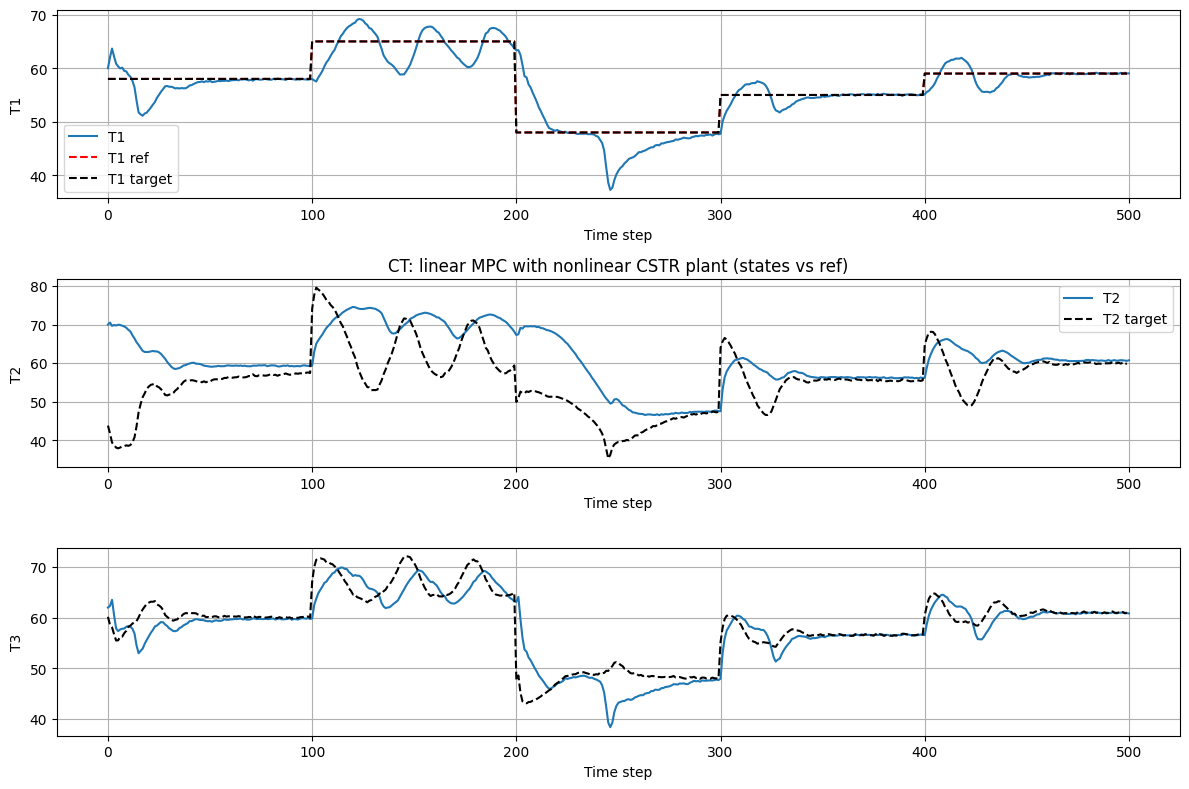

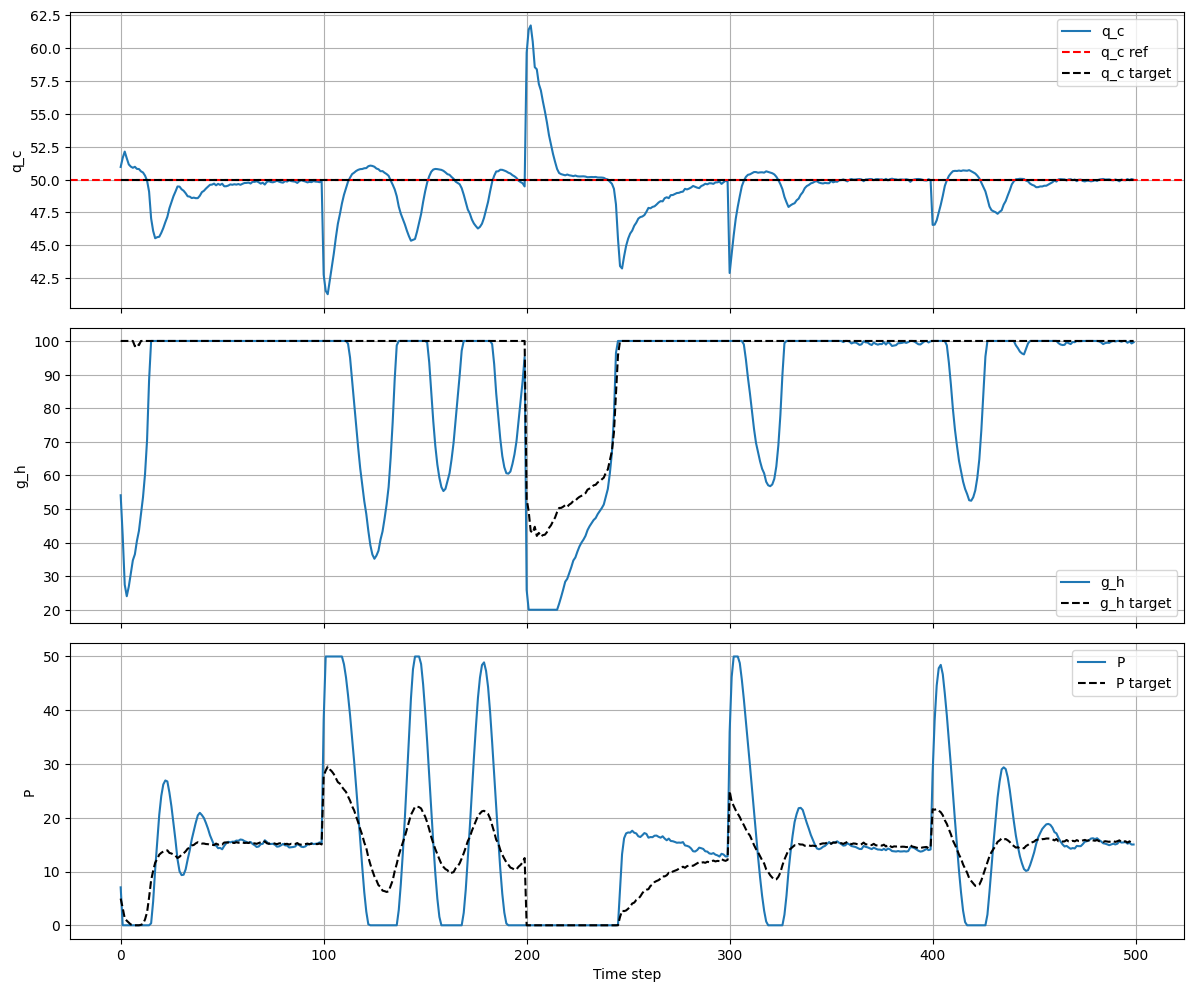

In [ ]:
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
Qdu = loaded_setup['Qdu']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
control_setpoint_cost = 0.0
for k in range(sim_time):
    y_ref_k = ys_energy_sim[:, k]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    u_error = us_energy_sim[:, k] - u_sim[:, k]
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qdu @ u_diff)
    u_sp_term = float(u_error.T @ Qu @ u_error)
    state_error_cost += y_term
    control_increment_cost += u_term
    control_setpoint_cost += u_sp_term
    objective_value += y_term + u_term + u_sp_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")
print(f"  - Input setpoint term: {control_setpoint_cost}")

Qu = loaded_setup['Qu_te']
Qy = loaded_setup['Qy_te']
objective_value = 0.0
state_error_cost = 0.0
control_setpoint_cost = 0.0
for k in range(sim_time):
    y_ref_k = loaded_setup['reference'][:, k]
    y_diff = y_sim[:, k] - y_ref_k
    u_error = us_energy_sim[:, k] - u_sim[:, k]
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_sp_term = float(u_error.T @ Qu @ u_error)
    state_error_cost += y_term
    control_setpoint_cost += u_sp_term
    objective_value += y_term + u_term + u_sp_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input setpoint term: {control_setpoint_cost}")




# Plots saved to figures/ in non-scaled domain (8 states, 4 inputs)
ys_sim_ns = scaler.inverse_transform(ys_energy_sim.T).T
zs_sim_ns = scaler.inverse_transform((C@zs_energy_sim + z_sim[nz:]).T).T
y_ests = scaler.inverse_transform((C@z_sim[:nz]).T).T
us_sim_ns = scalerU.inverse_transform(us_energy_sim.T).T

names = ['T1','T2','T3']
n_steps = sim_time

fig, axs = plt.subplots(nrows=min(8, ny), ncols=1, figsize=(12, 8))
if min(8, ny) == 1:
    axs = [axs]  # Ensure axs is always iterable
for i in range(min(8, ny)):
    ax = axs[i]
    # Actual output
    ax.plot(y_sim_ns[i, :], label=names[i] if i < len(names) else f'y{i}')
    # Reference trajectory
    if i == 0:
        ax.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
    # Target/Estimated reference
    ax.plot(ys_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    # State estimate (plot on top)
    # ax.plot(y_ests[i, :n_steps], 'g:', label=f'{names[i]} est' if i < len(names) else f'y{i} est')
    ax.set_xlabel('Time step')
    ax.set_ylabel(names[i] if i < len(names) else f'y{i}')
    ax.grid(True)
    if i in (0,1):
        ax.legend()
    if i == 1:
        ax.set_title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()
# fig.savefig((figures_dir / 'CT_states.png').as_posix(), dpi=200)


fig_inputs, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
input_names = ['q_c', 'g_h', 'P']
for i in range(len(input_names)):
    axs[i].plot(u_sim_ns[i, :], label=input_names[i])
    if i == 0:
        axs[i].axhline(scalerU.inverse_transform(u_sp.reshape(1, -1))[0][i], color='r', linestyle='--',
                       label=f'{input_names[i]} ref')
    axs[i].plot(us_sim_ns[i, :], 'k--', label=f"{input_names[i]} target")
    
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()
#649

In [29]:
sum(u_sim_ns[2,:])

np.float64(7430.811896537924)

In [30]:
sum(sum(z_sim[nz:,:]))

np.float64(-554.1490118422563)

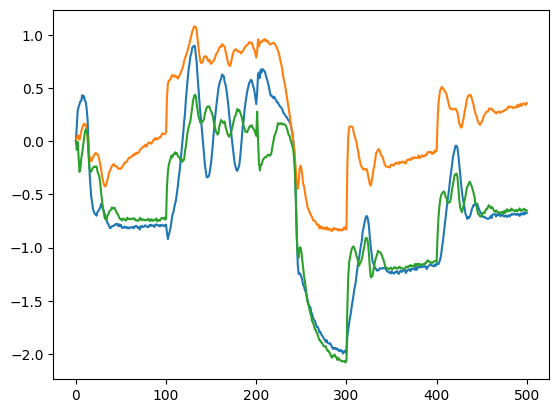

In [31]:
plt.plot(z_sim[nz:,:].T)

In [32]:
C@z_sim[:nz] + z_sim[nz:]

array([[ 0.67623006,  0.96636014,  1.19698725, ...,  0.55689034,
         0.53637705,  0.53836877],
       [-0.06191781,  0.01091301, -0.11028135, ..., -1.38853517,
        -1.40038441, -1.37752209],
       [ 0.67019906,  0.71184232,  0.86601928, ...,  0.5363051 ,
         0.52974066,  0.51981159]])

In [33]:
scaler.inverse_transform((C@z_sim[:nz] + z_sim[nz:]).T).T

array([[60.        , 62.03921806, 63.66021149, ..., 59.16120486,
        59.01702444, 59.03102356],
       [70.        , 70.51298043, 69.65935365, ..., 60.65603238,
        60.57257279, 60.7336025 ],
       [62.        , 62.32295642, 63.51864644, ..., 60.96161096,
        60.91070165, 60.83369871]])